In [1]:
#This notebook also uses the `(some) LaTeX environments for Jupyter`
#https://github.com/ProfFan/latex_envs wich is part of the
#jupyter_contrib_nbextensions package

from myhdl import *
from myhdlpeek import Peeker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sympy import *
init_printing()

import itertools

#EE drawing tools in python from https://cdelker.bitbucket.io/SchemDraw/
import SchemDraw as schem
import SchemDraw.elements as e
import SchemDraw.logic as l

#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information myhdl, myhdlpeek, numpy, pandas, matplotlib, sympy, itertools, SchemDraw

Software,Version
Python,3.6.5 64bit [GCC 7.2.0]
IPython,6.4.0
OS,Linux 4.15.0 33 generic x86_64 with debian buster sid
myhdl,0.10
myhdlpeek,0.0.7
numpy,1.14.3
pandas,0.23.0
matplotlib,2.2.2
sympy,1.4.dev
itertools,The 'itertools' distribution was not found and is required by the application


In [17]:
z, r, DisAng=symbols('z, r, Omega')
zFunc=Eq(z, r*exp(1j*DisAng)); zFunc

In [18]:
zFuncN=lambdify((r, DisAng), zFunc.rhs, dummify=False)

zr=np.arange(-1.5, 1.5+.03, .03); zi=np.copy(zr)
zR, zI=np.meshgrid(zr, zi)
zN=zR+1j*zI

rN=1.0
AngThetaN=np.arange(0, 1+.005, .005)*2*np.pi
zAtR1=zFuncN(rN, AngThetaN)

In [19]:
%matplotlib notebook





def Zplot(zR, zI, HzNMag, HzAtR1NMag, HzNPhase, HzAtR1NPhase, title):
    
    
    fig = plt.figure()

    #plot the z space mag
    axZmag = fig.add_subplot(221, projection='3d')
    Mags=axZmag.plot_surface(zR, zI, HzNMag, cmap=plt.get_cmap('tab20'))
    axZmag.plot(np.real(zAtR1), np.imag(zAtR1), HzAtR1NMag, 'r-', label='r=1')
    axZmag.set_xlabel('Re'); axZmag.set_ylabel('Im'); axZmag.set_zlabel('Mag')
    axZmag.legend(loc='best')
    fig.colorbar(Mags)

    #plot the z space phase
    axZph = fig.add_subplot(222, projection='3d')
    Phase=axZph.plot_surface(zR, zI, HzNPhase, cmap=plt.get_cmap('tab20'))
    axZph.plot(np.real(zAtR1), np.imag(zAtR1), HzAtR1NPhase, 'r-', label='r=1')
    axZph.set_xlabel('Re'); axZph.set_ylabel('Im'); axZph.set_zlabel('Phase')
    axZph.legend(loc='best')
    fig.colorbar(Phase)


    axBodeM=fig.add_subplot(212)
    Mline=axBodeM.plot(AngThetaN, HzAtR1NMag, label='FTMag')
    axBodeM.set_ylabel('Mag')

    axBodeP=axBodeM.twinx()
    Pline=axBodeP.plot(AngThetaN, np.rad2deg(HzAtR1NPhase), 'g--', label='FTPhase')
    axBodeP.set_ylabel('Phase [deg]')
    axBodeP.set_xlabel('Ang')


    lns = Mline+Pline
    labs = [l.get_label() for l in lns]
    axBodeP.legend(lns, labs, loc='best')
    
    fig.suptitle(title)
    fig.show()


In [20]:
N=symbols('N')
DelayH=z**(-N); DelayH

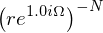

In [21]:
DelaySupH=simplify(DelayH.subs(zFunc.lhs, zFunc.rhs)); DelaySupH

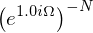

In [22]:
DelaySupH=simplify(DelaySupH.subs(r, 1)); DelaySupH

In [26]:
DelayHN=lambdify((z, N), DelayH, dummify=False)
Nvalue=2
HzN=DelayHN(zN, N=Nvalue); HzN.shape
HzNMag=np.abs(HzN); HzNPhase=np.angle(HzN)

HAtR1=zFuncN(rN, AngThetaN)
HzAtR1N=DelayHN(zAtR1, N=Nvalue)
HzAtR1NMag=np.abs(HzAtR1N); HzAtR1NPhase=np.angle(HzAtR1N)

In [31]:
def DelayExplorer(N=1):
    Nvalue=N
    
    HzN=DelayHN(zN, N=Nvalue); HzN.shape
    HzNMag=np.abs(HzN); HzNPhase=np.angle(HzN)

    HAtR1=zFuncN(rN, AngThetaN)
    HzAtR1N=DelayHN(zAtR1, N=Nvalue)
    HzAtR1NMag=np.abs(HzAtR1N); HzAtR1NPhase=np.angle(HzAtR1N)
    Zplot(zR, zI, HzNMag, HzAtR1NMag, HzNPhase, HzAtR1NPhase, 
          f'z Delay order N={N}')

In [32]:
# will add widgets for interative later
DelayExplorer(N=1)

<IPython.core.display.Javascript object>

ValueError: Unknown projection '3d'

In [34]:
@block
def Delay(x, y, read, clk):
    '''
        Z delay bulding block for a CIC filter
        
        Inputs:
            x (bitVec): the x(n) data in feed
            ------------------------
            read (bool): the exstiror calc hold input. calc is done only if 
            `read` is True
            
            clk(bool): clock feed
            rst(bool): reset feed
        
        Outputs:
            y (data):  the y(n+1) output of y(n+1)=x(n)
            
    '''
    @always(clk. posedge)
    def logic():
        if read:
            y.next=x
    return logic

In [ ]:
Peeker.clear()
x=Signal(modbv(0)[BitWidth:]); Peeker(x, 'x')
y=Signal(modbv(0)[BitWidth:]); Peeker(y, 'y')

read, clk=[Signal(bool(0)) for  _ in range(2)]
Peeker(ena_in, 'ena_in'); Peeker(clk, 'clk')

DUT=Delay(x, y, read, clk)

DateCol=pd.DataFrame(columns=['x', 'y', 'ena_in'])

def Delay_TB():
    
    @always(delay(1))  ## delay in nano seconds
    def clkGen():
        clk.next = not clk
        
    @instance
    def stimulus():
        Tested_read=False
        count=0
        while 1:
            
            if Tested_read==False and count<=2:
                print(f'Tested_read: {Tested_ena}, count:{count}')
            elif Tested_read==False and count>2:
                print(f'Tested_read: {Tested_ena}, count:{count}')

                ena_in.next=True
                Tested_ena=True
                x.next=0
           
            
            if Tested_ena  and count>2:
                x.next=x+1
            
            if count> 2*BitWidth:
                raise StopSimulation
            
            DateCol.loc[count]=[int(x),int(y), int(ena_in)]
            
            count+=1
            yield clk.posedge
                
                
            
    return instances()
sim = Simulation(DUT, Delay_TB(), *Peeker.instances()).run()